<a href="https://colab.research.google.com/github/m-shilpa/machine_learning/blob/master/Copy_of_FaceSwap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Source: https://github.com/spmallick/PyImageConf2018/blob/master/FaceSwap.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# Import modules
import sys, cv2,dlib, time
import numpy as np
# import faceBlendCommon as fbc
import matplotlib.pyplot as plt

In [3]:
# Read images
img2 = cv2.imread('/content/srk.jpg')
img1 = cv2.imread('/content/rk.jpg')


# Convert images from one bgr color space to rgb
im1Display = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
im2Display = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1Warped = np.copy(img2)

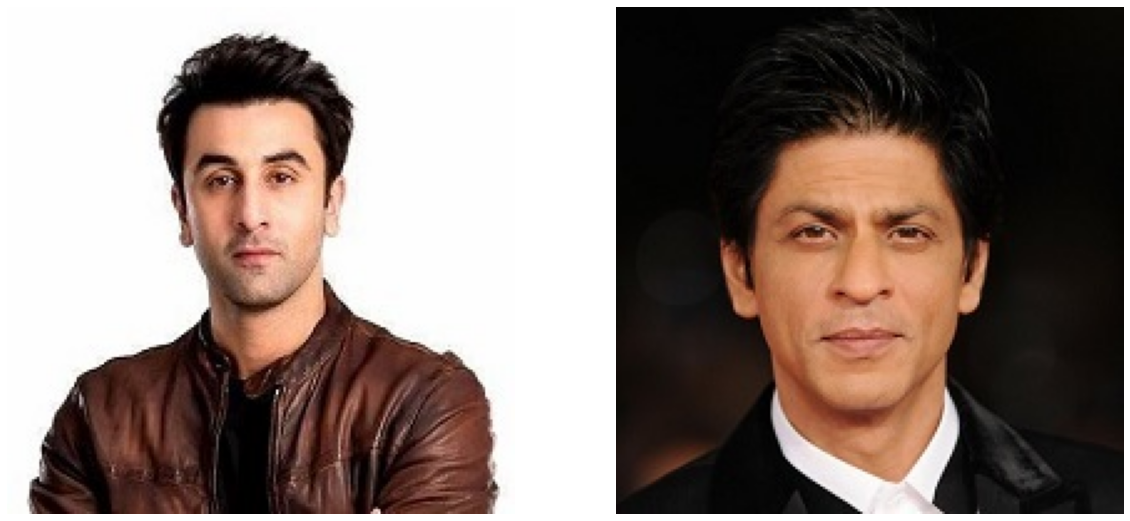

In [4]:
# Display Images 
plt.figure(figsize = (20,10))
plt.subplot(121); plt.imshow(im1Display); plt.axis('off');
plt.subplot(122); plt.imshow(im2Display); plt.axis('off');

In [ ]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2020-08-07 04:48:29--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  18.4MB/s    in 5.1s    

2020-08-07 04:48:34 (12.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [5]:
# %%file faceBlendCommon.py

import math
# detect facial landmarks in image
def getLandmarks(faceDetector, landmarkDetector, im, FACE_DOWNSAMPLE_RATIO = 1):
  points = []
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO, 
                       fy=1.0/FACE_DOWNSAMPLE_RATIO, 
                       interpolation = cv2.INTER_LINEAR)
  
  faceRects = faceDetector(imSmall, 0)
  
  if len(faceRects) > 0:
    maxArea = 0
    maxRect = None
    # TODO: test on images with multiple faces
    for face in faceRects:
      if face.area() > maxArea:
        maxArea = face.area()
        maxRect = [face.left(),
                   face.top(),
                   face.right(),
                   face.bottom()
                  ]
    
    rect = dlib.rectangle(*maxRect)
    scaledRect = dlib.rectangle(int(rect.left()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.top()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.right()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.bottom()*FACE_DOWNSAMPLE_RATIO))
    
    landmarks = landmarkDetector(im, scaledRect)
    points = dlibLandmarksToPoints(landmarks)
  return points

# convert Dlib shape detector object to list of tuples
def dlibLandmarksToPoints(shape):
  points = []
  for p in shape.parts():
    pt = (p.x, p.y)
    points.append(pt)
  return points

# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int(xin), np.int(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateAffine2D for calculating the similarity transform.
  tform = cv2.estimateAffine2D(np.array([inPts]), np.array([outPts]), False)
  return tform

def normalizeImagesAndLandmarks(outSize,imIn,pointsIn):
  h, w = outSize

  # Corners of the eye in the input image
  if len(pointsIn) == 68:
    eyecornerSrc = [pointsIn[36],pointsIn[45]]
  elif len(pointsIn) == 5:
    eyecornerSrc = [pointsIn[2],pointsIn[0]]
  
  # Corners of the eye i  normalized image
  eyecornerDst = [(np.int(0.3*w),np.int(h/3)),(np.int(0.7*w),np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform[0], (w,h))

  # reshape pointsIn from numLandmarks x 2 to  numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn,(pointsIn.shape[0],1,pointsIn.shape[1]))

  # Apply similarity transform to landmarks
  pointsOut = cv2.transform(points2,tform[0])

  # reshape pointsOut to numLandmarks x 2
  pointsOut = np.reshape(pointsOut,(pointsIn.shape[0],pointsIn.shape[1]))

  return imOut, pointsOut


# Check if a point is inside a rectangle
def rectContains(rect, point):
  if point[0] < rect[0]:
    return False
  elif point[1] < rect[1]:
    return False
  elif point[0] > rect[2]:
    return False
  elif point[1] > rect[3]:
    return False
  return True

# Calculate Delaunay triangles for set of points
# Returns the vector of indices of 3 points for each triangle
def calculateDelaunayTriangles(rect, points):

  # Create an instance of Subdiv2D
  subdiv = cv2.Subdiv2D(rect)

  # Insert points into subdiv
  for p in points:
    subdiv.insert((p[0], p[1]))

  # Get Delaunay triangulation
  triangleList = subdiv.getTriangleList()

  # Find the indices of triangles in the points array
  delaunayTri = []

  for t in triangleList:
    # The triangle returned by getTriangleList is
    # a list of 6 coordinates of the 3 points in
    # x1, y1, x2, y2, x3, y3 format.
    # Store triangle as a list of three points
    pt = []
    pt.append((t[0], t[1]))
    pt.append((t[2], t[3]))
    pt.append((t[4], t[5]))

    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
      # Variable to store a triangle as indices from list of points
      ind = []
      # Find the index of each vertex in the points list
      for j in range(0, 3):
        for k in range(0, len(points)):
          if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
            ind.append(k)
        # Store triangulation as a list of indices
      if len(ind) == 3:
        delaunayTri.append((ind[0], ind[1], ind[2]))

  return delaunayTri

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size):

  # Given a pair of triangles, find the affine transform.
  warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

  # Apply the Affine Transform just found to the src image
  dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None,
             flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

  return dst

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2):
  # Find bounding rectangle for each triangle
  r1 = cv2.boundingRect(np.float32([t1]))
  r2 = cv2.boundingRect(np.float32([t2]))

  # Offset points by left top corner of the respective rectangles
  t1Rect = []
  t2Rect = []
  t2RectInt = []

  for i in range(0, 3):
    t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
    t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    t2RectInt.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

  # Get mask by filling triangle
  mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
  cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0)

  # Apply warpImage to small rectangular patches
  img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]

  size = (r2[2], r2[3])

  img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)

  img2Rect = img2Rect * mask

  # Copy triangular region of the rectangular patch to the output image
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect

In [6]:
# Initialize the dlib facial landmakr detector
path = '/content/gdrive/My Drive/e4p2/s3/'
predictor_path = path + 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
# Read array of corresponding points
points1 = getLandmarks(detector, predictor, img1)
points2 = getLandmarks(detector, predictor, img2)

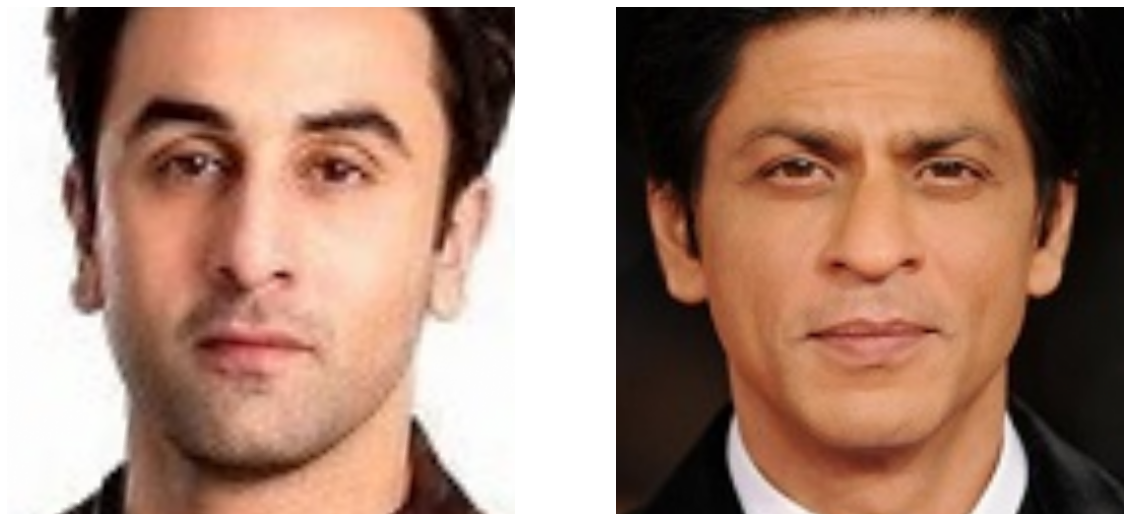

In [18]:
def align_face(im,faceDetector,landmarkDetector):
  points = getLandmarks(faceDetector,landmarkDetector,im)

  points = np.array(points)

  im = np.float32(im)/255.0
  h = 500
  w = 500

  imNorm, points = normalizeImagesAndLandmarks((h,w),im,points)
  imNorm = np.uint8(imNorm*255)
  return imNorm

im1 = align_face(img1, detector, predictor)
im2 = align_face(img2, detector, predictor)
plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(im1[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(im2[:,:,::-1]); plt.axis('off');

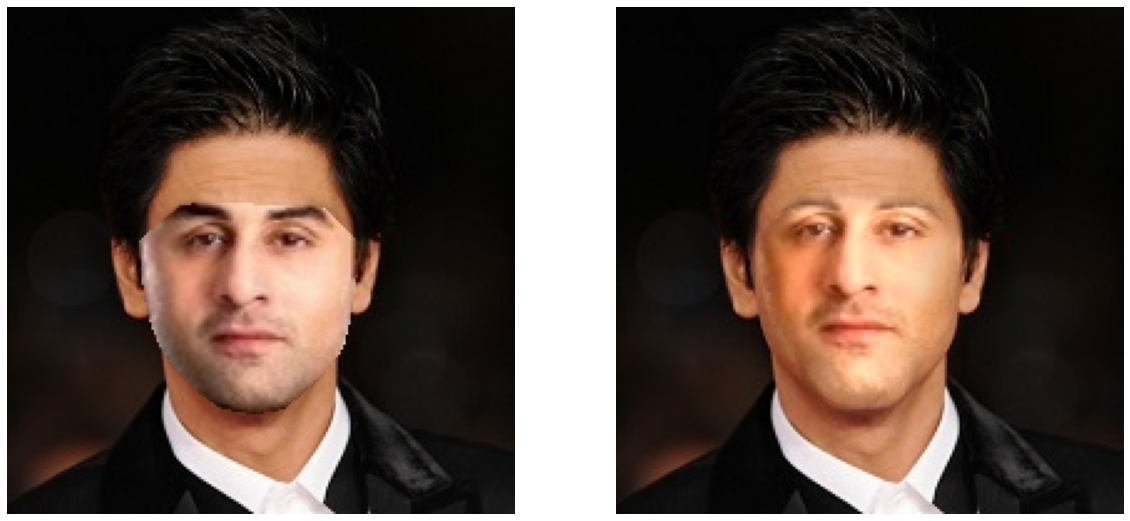

In [12]:
# Find convex hull
hullIndex = cv2.convexHull(np.array(points2), returnPoints=False)

# Create convex hull lists
hull1 = []
hull2 = []
for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i][0]])
    hull2.append(points2[hullIndex[i][0]])

# convert to list of tuples
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))
    
# Calculate Mask for Seamless cloning
mask = np.zeros(img2.shape, dtype=img2.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

# Find Delaunay traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = calculateDelaunayTriangles(rect, hull2)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

imTemp1 = im1Display.copy()
imTemp2 = im2Display.copy()

tris1 = []
tris2 = []
for i in range(0, len(dt)):
    tri1 = []
    tri2 = []
    for j in range(0, 3):
        tri1.append(hull1[dt[i][j]])
        tri2.append(hull2[dt[i][j]])

    tris1.append(tri1)
    tris2.append(tri2)

# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris1)):
    warpTriangle(img1, img1Warped, tris1[i], tris2[i])
    
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');

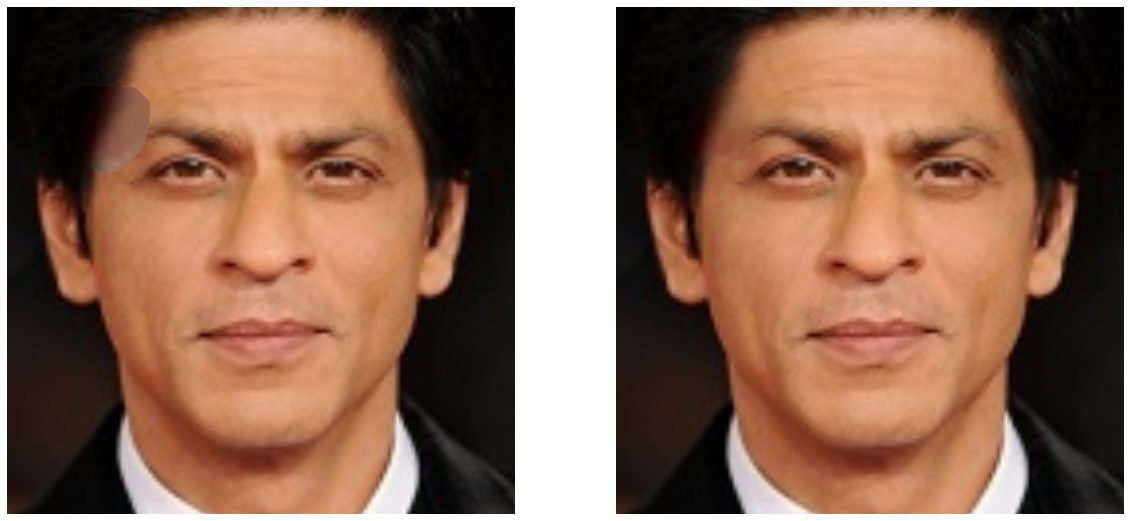

In [19]:
# Read images
im2 = cv2.imread('/content/srk.jpg')
im1 = cv2.imread('/content/rk.jpg')

# align face
img1 = align_face(im1, detector, predictor)
img2 = align_face(im2, detector, predictor)

# Convert images from one bgr color space to rgb
im1Display = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
im2Display = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1Warped = np.copy(img2)


# Find convex hull
hullIndex = cv2.convexHull(np.array(points2), returnPoints=False)

# Create convex hull lists
hull1 = []
hull2 = []
for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i][0]])
    hull2.append(points2[hullIndex[i][0]])

# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

# Find Delaunay traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = calculateDelaunayTriangles(rect, hull2)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

imTemp1 = im1Display.copy()
imTemp2 = im2Display.copy()

tris1 = []
tris2 = []
for i in range(0, len(dt)):
    tri1 = []
    tri2 = []
    for j in range(0, 3):
        tri1.append(hull1[dt[i][j]])
        tri2.append(hull2[dt[i][j]])

    tris1.append(tri1)
    tris2.append(tri2)

# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris1)):
    warpTriangle(img1, img1Warped, tris1[i], tris2[i])
    
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');

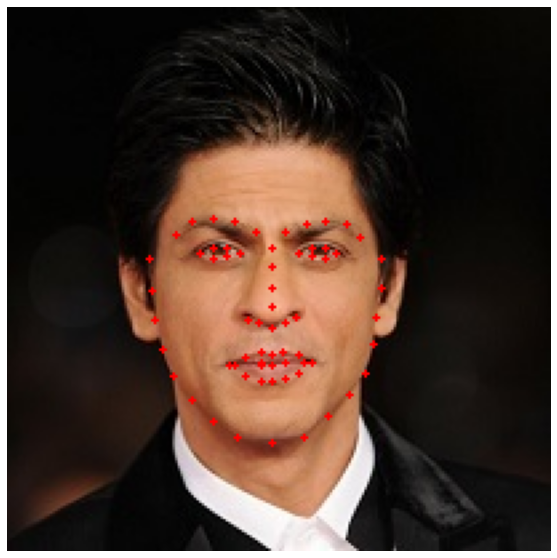

In [ ]:
# Display Landmarks
imTemp = im2Display.copy()
for p in points2:
    cv2.circle(imTemp, p, 1, (255,0,0), -1)

plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [ ]:
# Find convex hull
hullIndex = cv2.convexHull(np.array(points2), returnPoints=False)

# Create convex hull lists
hull1 = []
hull2 = []
for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i][0]])
    hull2.append(points2[hullIndex[i][0]])

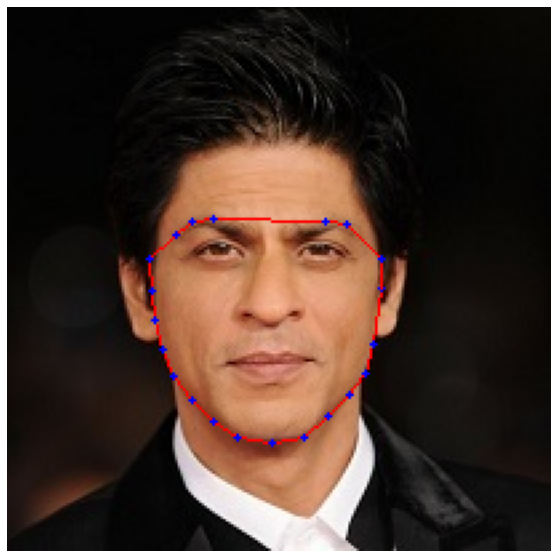

In [ ]:
# Display Convex Hull
imTemp = im2Display.copy()
numPoints = len(hull2)
for i in range(0, numPoints):
    cv2.line(imTemp, hull2[i], hull2[(i+1)%numPoints], (255,0,0), 1)
    cv2.circle(imTemp, hull2[i], 1, (0,0,255), -1)
plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [ ]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

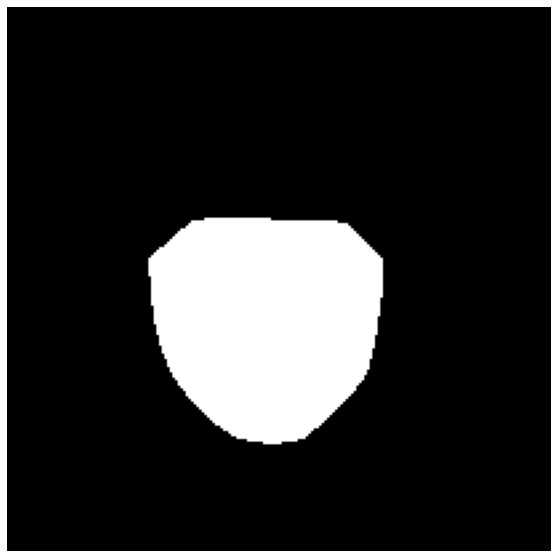

In [ ]:
# Display Mask
plt.figure(figsize = (20,10)); plt.imshow(mask); plt.axis('off');

In [ ]:
# Find Delaunay traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = calculateDelaunayTriangles(rect, hull2)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

In [ ]:
imTemp1 = im1Display.copy()
imTemp2 = im2Display.copy()

tris1 = []
tris2 = []
for i in range(0, len(dt)):
    tri1 = []
    tri2 = []
    for j in range(0, 3):
        tri1.append(hull1[dt[i][j]])
        tri2.append(hull2[dt[i][j]])

    tris1.append(tri1)
    tris2.append(tri2)

cv2.polylines(imTemp1,np.array(tris1),True,(0,0,255),1);
cv2.polylines(imTemp2,np.array(tris2),True,(0,0,255),1);

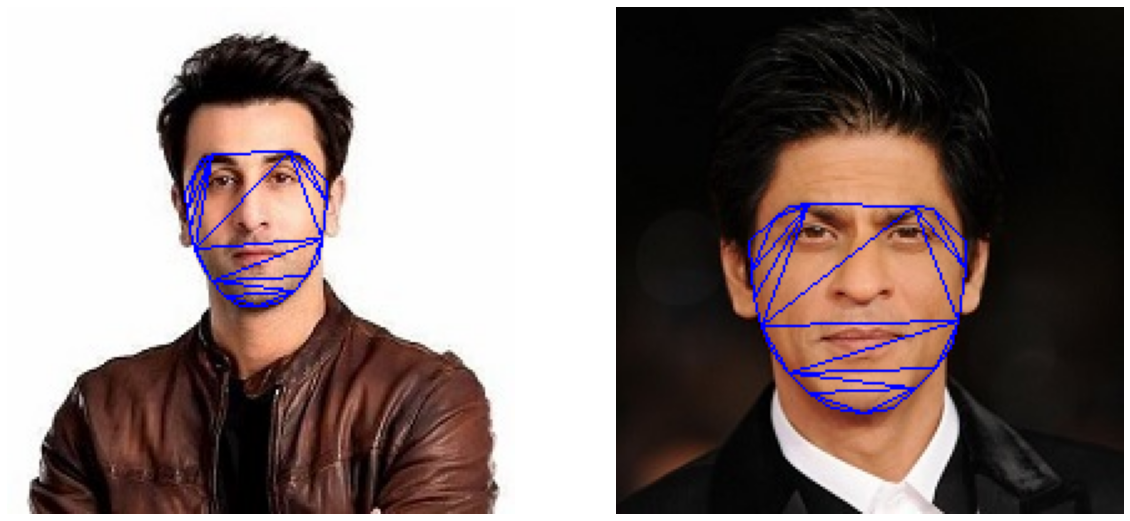

In [ ]:
# Display Triangulation
plt.figure(figsize = (20,10)); 
plt.subplot(121); plt.imshow(imTemp1); plt.axis('off');
plt.subplot(122); plt.imshow(imTemp2); plt.axis('off');

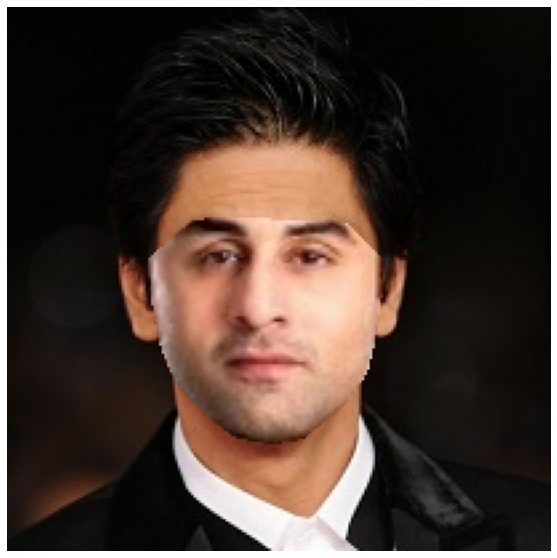

In [ ]:
# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris1)):
    warpTriangle(img1, img1Warped, tris1[i], tris2[i])

plt.figure(figsize=(20,10));
plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');

In [ ]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

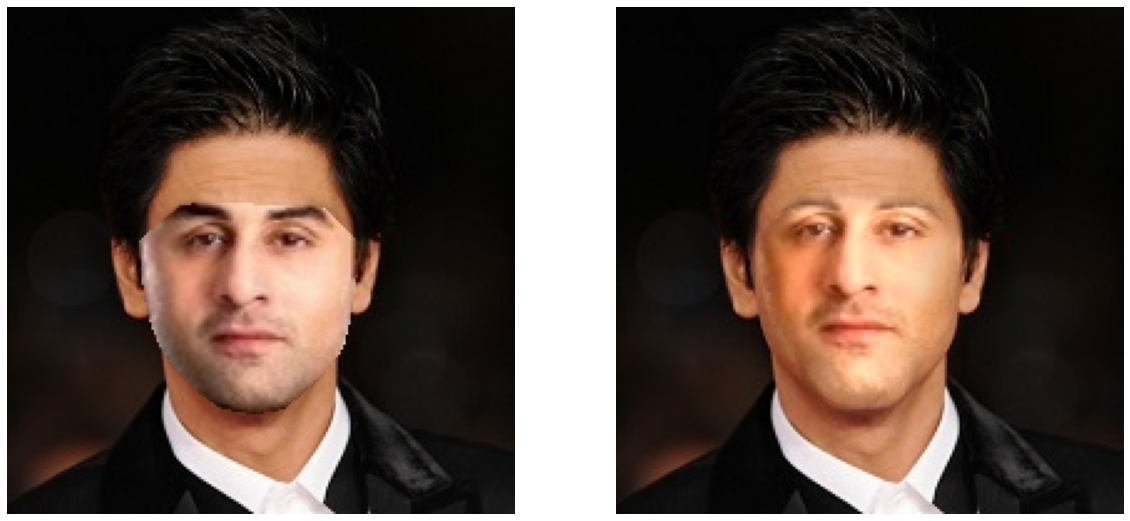

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');

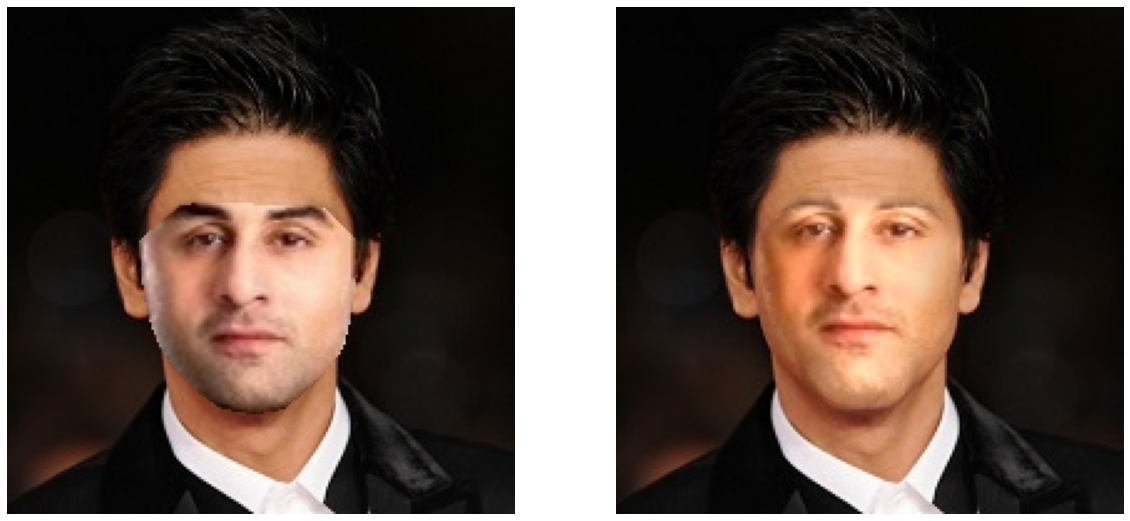

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');

In [ ]:
# Initialize the dlib facial landmakr detector
detector = dlib.get_frontal_face_detector()
path = '/content/gdrive/My Drive/e4p2/s3/'
predictor_path = path + 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)
# Read array of corresponding points
points1 = getLandmarks(detector, predictor, img1)
points2 = getLandmarks(detector, predictor, img2)


# Find convex hull
hullIndex = cv2.convexHull(np.array(points2), returnPoints=False)

# Create convex hull lists
hull1 = []
hull2 = []
for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i][0]])
    hull2.append(points2[hullIndex[i][0]])

# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))


# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)